In [1]:
%%html
<style>
.output_subarea.output_text.output_stream.output_stdout > pre {
    width:max-content;
}
.p-Widget.jp-RenderedText.jp-OutputArea-output > pre {
   width:max-content;
}
</style>

In [2]:
from pyspark.sql import Row, SparkSession
from pyspark.sql.functions import udf, when, rand, struct, col, lit, current_date, current_timestamp, monotonically_increasing_id
from pyspark.sql.types import StringType, IntegerType, StructField, StructType, DoubleType, ArrayType, FloatType

In [3]:
from ophelia.spark.OpheliaMain import Ophelia
from ophelia.spark.read.spark_read import Read
from ophelia.spark.ml.feature_miner import FeatureMiner

In [4]:
ophelia = Ophelia("CRC Model")
sc = ophelia.Spark.build_spark_context()

01:56:47.933 Ophelia [WARN] Initializing Spark Session
01:56:56.867 Ophelia [INFO] Spark Version: 3.0.0
01:56:56.867 Ophelia [INFO] This Is: 'CRC Model' App
01:56:56.867 Ophelia [INFO] Spark Context Initialized Success


In [5]:
spark = ophelia.SparkSession
path = "ophelia_dev/data/raw/csv/bank.csv"

customer_data = spark.readFile(path, 'csv', header=True, infer_schema=True)
customer_data.printSchema()
customer_data.show(5, False)

01:56:56.874 Ophelia [INFO] Read CSV File From Path: ophelia_dev/data/raw/csv/bank.csv
root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)

+---+----------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
|age|job       |marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|pout

In [6]:
string_feature = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'deposit']
indexed_df = customer_data.toStringIndex(string_feature)
indexed_df.show(5, False)

01:57:00.216 Ophelia [INFO] Creating Multi String Indexers
01:57:02.540 Ophelia [INFO] Build String Indexer
+---+----------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+---------+-------------+---------------+-------------+-------------+----------+-------------+-----------+--------------+-------------+
|age|job       |marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|deposit|job_index|marital_index|education_index|default_index|housing_index|loan_index|contact_index|month_index|poutcome_index|deposit_index|
+---+----------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+---------+-------------+---------------+-------------+-------------+----------+-------------+-----------+--------------+-------------+
|59 |admin.    |married|secondary|no     |2343   |yes    |no  |unknown|5  |may  |1042    |1   

In [7]:
indexed_feature = [f'{c}_index' for c in string_feature]
encoded_df = indexed_df.toOHEncoder(string_feature).drop(*indexed_feature)
encoded_df.show(5, False)
encoded_df.printSchema()

01:57:02.928 Ophelia [INFO] Creating Multi String Indexers
01:57:02.957 Ophelia [INFO] Creating Feature Encoders
01:57:03.032 Ophelia [INFO] Build One Hot Encoder
+---+----------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+-------------------+---------------------+---------------------+----------------------+---------------------+------------------+---------------------+---------------------+-----------------------+-----------------+
|age|job       |marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|deposit|month_index_encoded|contact_index_encoded|deposit_index_encoded|poutcome_index_encoded|marital_index_encoded|loan_index_encoded|default_index_encoded|housing_index_encoded|education_index_encoded|job_index_encoded|
+---+----------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+--------------

In [ ]:
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
np.random.seed(0)

# 10 samples with 5 features
train_features = np.random.rand(10,5)

model = PCA(n_components=2).fit(train_features)
X_pc = model.transform(train_features)

# number of components
n_pcs= model.components_.shape[0]

# get the index of the most important feature on EACH component
# LIST COMPREHENSION HERE
most_important = [np.abs(model.components_[i]).argmax() for i in range(n_pcs)]

initial_feature_names = ['a','b','c','d','e']

# get the names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

# LIST COMPREHENSION HERE AGAIN
dic = {'PC{}'.format(i+1): most_important_names[i] for i in range(n_pcs)}

# build the dataframe
df = pd.DataFrame(sorted(dic.items()))
df

In [ ]:
dic

In [ ]:
# esto es el "df" con 10 filas y 5 columnas

train_features.shape

In [ ]:
# esto es el "df" reducido a solo 2 componentes, se mantienen las filas

X_pc.shape

In [ ]:
n_pcs

In [ ]:
# esto es 2 componentes como filas y 5 columnas que son las features originales

(model.components_)

In [ ]:
[np.abs(model.components_[i]).argmax() for i in range(n_pcs)]

# Customer Feature Pattern C.F.P. Model

In [8]:
from ophelia.spark.ml.unsupervised.FeatureExtraction import SingularValueDecomposition

In [13]:
svd_df = SingularValueDecomposition(k=10).transform(encoded_df.drop(*string_feature))
svd_df.show(5)

01:58:33.552 Ophelia [INFO] Build Vector Assembler
01:58:33.577 Ophelia [INFO] Parsing Feature Vector To DenseUDT
01:58:33.601 Ophelia [INFO] Compute Feature Standard Scaler
01:58:34.447 Ophelia [INFO] Build Index RDD Row Matrix
01:58:36.421 Ophelia [WARN] Compute SVD With K=10, d=17, n=11162
01:58:36.508 Ophelia [INFO] Compute Eigenvalues & Eigenvectors From Hyperplane
01:58:36.508 Ophelia [INFO] Compute Variance For Each Component
01:58:36.508 Ophelia [INFO] Find K=10 Components For 95% Variance
01:58:36.527 Ophelia [INFO] Cumulative Variance Array:
[ 19.09538361  32.61878371  45.51444996  56.12162888  65.27026562
  73.01773819  80.09157152  87.0727075   93.67841016 100.        ]
01:58:36.527 Ophelia [WARN] Components For 75% Variance K=7
01:58:36.527 Ophelia [WARN] Components For 85% Variance K=8
01:58:36.527 Ophelia [WARN] Components For 95% Variance K=10
01:58:36.527 Ophelia [INFO] Fit Optimal PCA Model With K=10 Components
+---+--------------------+--------------------+----------

In [ ]:
from ophelia.spark.functions.transpose import TransposeDataFrame

In [ ]:
svd_df.toNarrow(['id'], ['vector_class', 'features']).where(col('vector_class') == 'pca_features').show(5, False)

# K-Means Customer Clusterization  K-M.C.C. Model

In [14]:
from pyspark.ml.clustering import KMeans

kmeans = KMeans(featuresCol='pca_features', k=5, seed=12345)
model_kmeans = kmeans.fit(svd_df)
kmean_df = model_kmeans.transform(svd_df)
kmean_df.groupBy("prediction").count().orderBy(col("prediction")).show()
kmean_df.show(5)

+----------+-----+
|prediction|count|
+----------+-----+
|         0| 2235|
|         1| 2850|
|         2| 2508|
|         3| 2290|
|         4| 1279|
+----------+-----+

+---+--------------------+--------------------+--------------------+----------+
| id|            features|     scaled_features|        pca_features|prediction|
+---+--------------------+--------------------+--------------------+----------+
|  0|[59.0,2343.0,5.0,...|[1.49143806707364...|[2.26966833061735...|         3|
|  1|[56.0,45.0,5.0,14...|[1.23962013449750...|[1.99479093778077...|         3|
|  2|[41.0,1270.0,5.0,...|[-0.0194695283832...|[2.25766097692147...|         3|
|  3|[55.0,2476.0,5.0,...|[1.15568082363878...|[2.48693764431651...|         3|
|  4|[54.0,184.0,5.0,6...|[1.07174151278007...|[1.53459167678433...|         3|
+---+--------------------+--------------------+--------------------+----------+
only showing top 5 rows



In [35]:
def extract(row):
    row_tuple = (
        row.id,
        row.features, 
        row.scaled_features,
        row.pca_features,
        row.prediction
    )
    return row_tuple + tuple(row.features.toArray().tolist())

fix_cols = [
    'id',
    'features',
    'scaled_features',
    'pca_features',
    'prediction'
]
extract_feature = kmean_df.rdd.map(extract).toDF(fix_cols)
no_name_cols = extract_feature.drop(*fix_cols).columns
named_cols = encoded_df.columns
cluster_feature = extract_feature.select(*fix_cols, *[col(c).alias(a) for c, a in zip(no_name_cols, named_cols)])

In [ ]:
encoded_df.

In [43]:
cluster_feature.where(col('prediction') == 3).groupBy('marital').count().orderBy('count').show(100)

+-------+-----+
|marital|count|
+-------+-----+
|   31.0|    1|
|   22.0|    1|
|   10.0|    1|
|   24.0|    3|
|    1.0|    8|
|   11.0|   36|
|   17.0|   48|
|    3.0|   57|
|    4.0|   60|
|    2.0|   63|
|    7.0|   66|
|   18.0|   66|
|   21.0|   71|
|    8.0|   74|
|   23.0|   82|
|   29.0|   83|
|   27.0|   87|
|   13.0|   88|
|   14.0|   89|
|   26.0|   91|
|   12.0|   91|
|   15.0|   93|
|   30.0|   97|
|   28.0|   97|
|   19.0|  111|
|    9.0|  119|
|   16.0|  124|
|    5.0|  131|
|    6.0|  151|
|   20.0|  201|
+-------+-----+



In [15]:
import matplotlib.pyplot as plt

def plot_k_pca(X, y):
    """
    a scatter plot of the 2-dimensional space
    """
    plt.style.use('fivethirtyeight')
    plt.rcParams['figure.figsize'] = 15, 7
    plt.rcParams['font.size'] = 12
    markers = 's', 'x', 'o', '.', '+'
    colors = list(plt.rcParams['axes.prop_cycle'])
    target = np.unique(y)
    for idx, (t, m) in enumerate(zip(target, markers)):
        subset = X[y == t]
        plt.scatter(subset[:, 0], subset[:, 1], s = 50,
                    c = colors[idx]['color'], label = t, marker = m)

    plt.xlim(-10, 10)
    plt.xlabel('PC 1')
    plt.ylim(-10, 10)
    plt.ylabel('PC 2')
    plt.legend(loc = 'upper right')
    plt.tight_layout()
    plt.show()


mat 'X' dim:(11162, 10) and vector 'y' dim:(11162,)

clustering with K=10



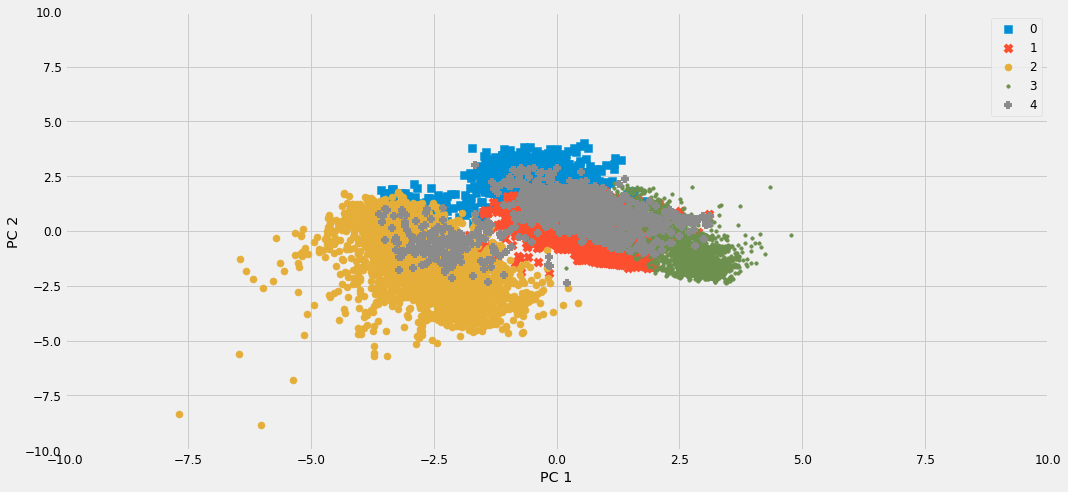

In [16]:
import numpy as np

def x_y_scatter(df):
    X_rdd = df.rdd.map(lambda row: row.pca_features)
    X_pca = np.array(X_rdd.collect())
    y_rdd = df.rdd.map(lambda row: row.prediction)
    y = np.array(y_rdd.collect())
    print(f"\nmat 'X' dim:{X_pca.shape} and vector 'y' dim:{y.shape}\n")
    print(f"clustering with K={X_pca.shape[1]}\n")
    return plot_k_pca(X_pca, y)

x_y_scatter(kmean_df)


mat 'X' dim:(2235, 10) and vector 'y' dim:(2235,)

clustering with K=10



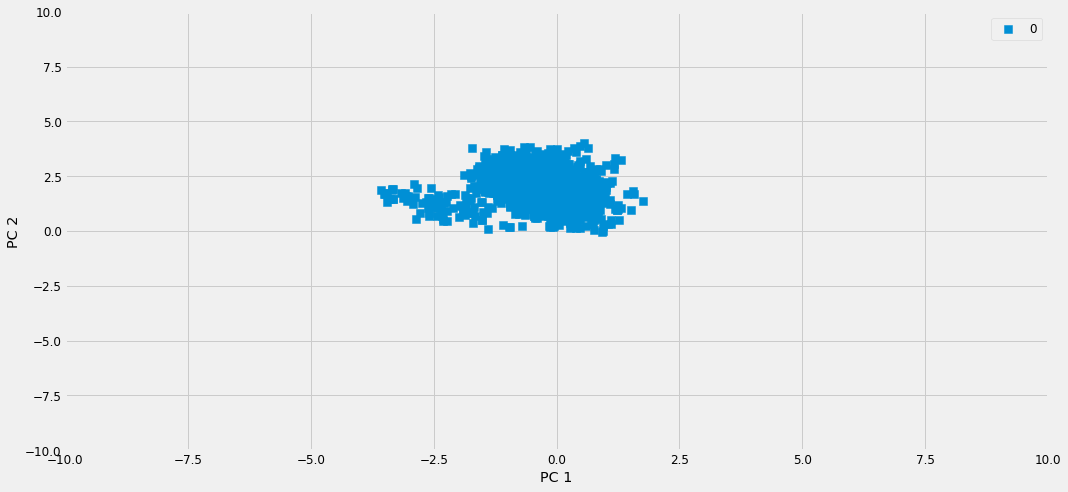


mat 'X' dim:(2850, 10) and vector 'y' dim:(2850,)

clustering with K=10



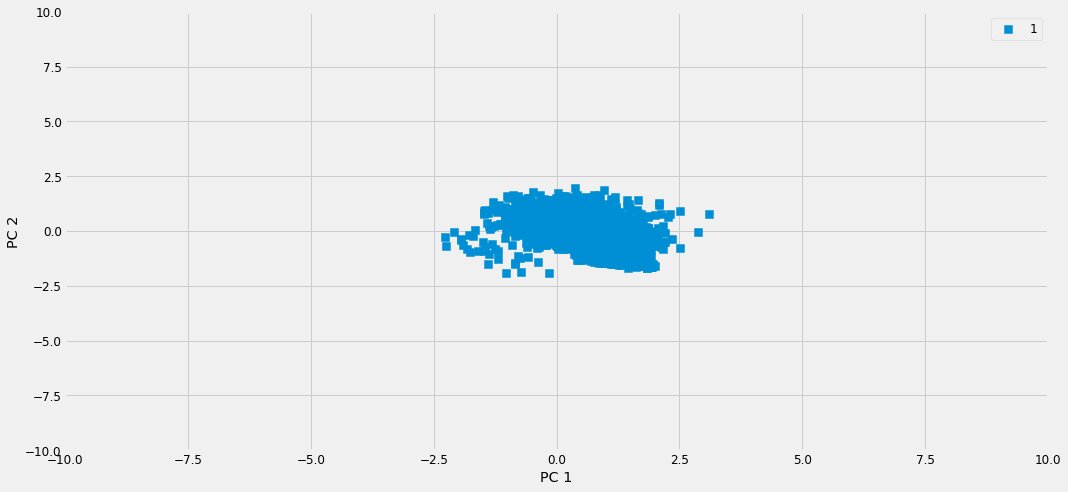


mat 'X' dim:(2508, 10) and vector 'y' dim:(2508,)

clustering with K=10



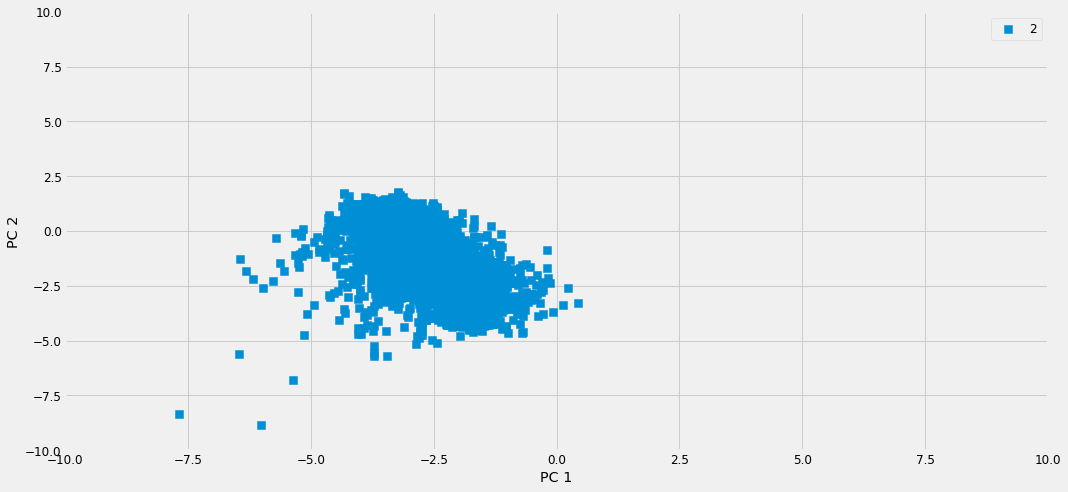


mat 'X' dim:(2290, 10) and vector 'y' dim:(2290,)

clustering with K=10



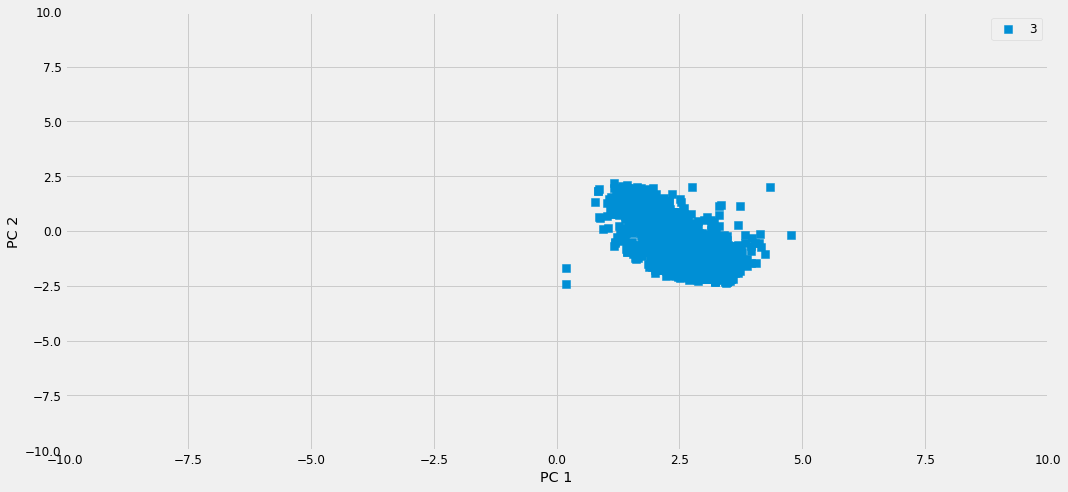


mat 'X' dim:(1279, 10) and vector 'y' dim:(1279,)

clustering with K=10



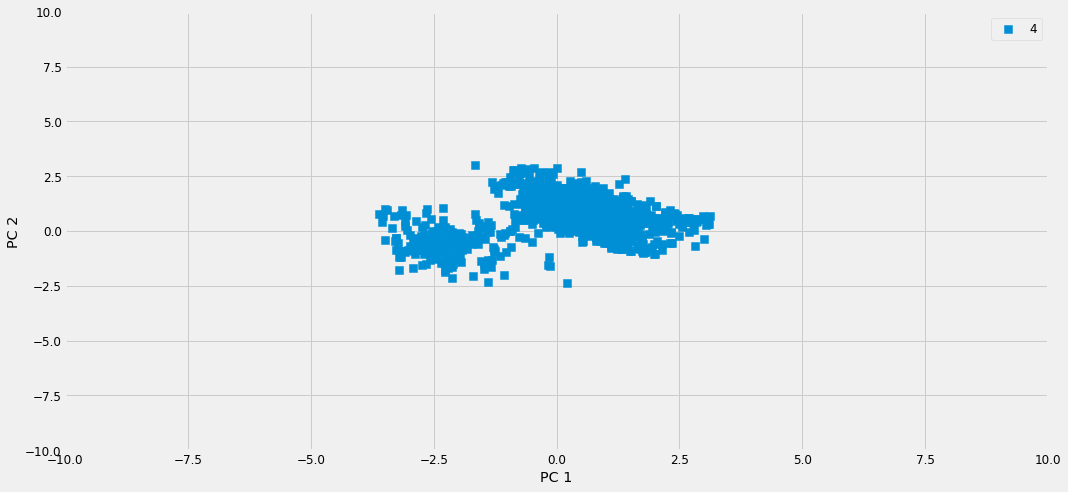

In [17]:
import numpy as np

for k in range(5):
    x_y_scatter(kmean_df.where(col('prediction') == k))